In [1]:
import numpy as np
import matplotlib.pyplot as plt
from consumption_saving import *
from copy import deepcopy
from estimation_consav import *

%load_ext autoreload
%autoreload 2

# %pip install EconModel
from Model import ReferenceDependenceClass
model = ReferenceDependenceClass()
model.par.full_sample_estimation = True
model.allocate()
model_new = deepcopy(model)



# **Estimating using the full sample** #
(using hazard rates from both before and after the reform)

# Model with reference dependence

In [2]:
est_par = ['gamma', 'lambdaa', 'N', 'cost1', 'cost2', 'type_shares1', 'welfare'] # Parameters to estimate
theta0 = [0.06, 2, 15, 100.0, 300, 0.4, 90/675]  # Initial guesses
bounds = [(0.01, 50.0), (0.0, 5.0), (0,50), (0.0,model.par.cost2), (model.par.cost1,1000.0), (0.0,1.0), (0.0,model.par.b3)] # Bounds for the parameters

# S: Hvorfor estimerer den ikke N, men accepterer bare initial guess?
# S: Bør vi løse problemet med initial guess ved at trække gættende fra en uniform fordeling som de gør i papiret?

est = method_simulated_moments(model,est_par,theta0,bounds,weight=False)

print("Optimization Results:")
print("---------------------")
print(f'{"Parameter":<15} {"Estimate":<15}')
for param, estimate in zip(est_par, est.x):
    print(f'{param:<15} {estimate:>15.3f}')
print(f'Objective:               {est.fun:.4f}')
print(f'Number of iterations:    {est.nit}')

sol.s
1.9821791173665626
sol.s
1.4738836153884105
sol.s
1.8202380269231861
sol.s
1.5910504039075064
sol.s
1.7481508969587447
sol.s
1.663390377838921
sol.s
1.7540406768035504
sol.s
1.7250761690218586
sol.s
1.7854367318959783
sol.s
1.7802754537685477
sol.s
1.8265277618973899
sol.s
1.9267756967939285
sol.s
2.0096321653845775
sol.s
2.11717372001401
sol.s
2.1978016636599573
sol.s
2.304696357919845
sol.s
2.371711161907763
sol.s
2.4846645511770875
sol.s
2.523357610363041
sol.s
2.666858460644346
sol.s
1.4322313779810927
sol.s
2.7940968399521813
sol.s
1.4822541837570604
sol.s
3.0746332140181347
sol.s
1.3733475435748355
sol.s
3.5270986056608447
sol.s
1.1131142186193277
sol.s
1.215989545221317
sol.s
1.312926167339299
sol.s
1.404732188444004
sol.s
1.4919508503469632
sol.s
1.5750197161729926
sol.s
1.6543051341150086
sol.s
1.730123757751944
sol.s
1.802752400121329
sol.s
1.8724358968007018
sol.s
1.939391887814983
sol.s
1.9821791173665626
sol.s
1.4738836153884105
sol.s
1.8202380269231861
sol.s
1.59105

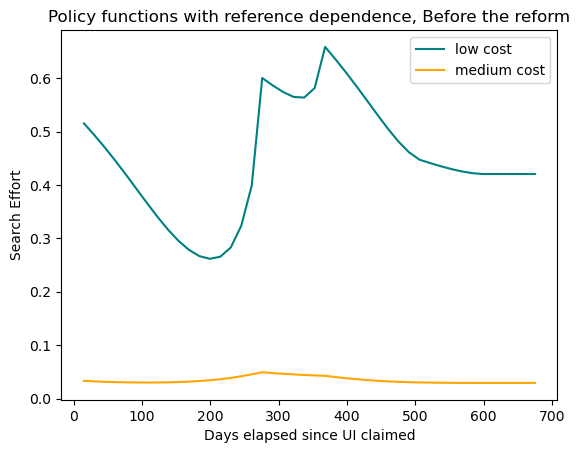

In [3]:
value_function_employment_ConSav(model.par, model.sol)
solve_search_and_consumption_ConSav(model.par, model.sol)
search_effort = model.sol.s
time = np.linspace(0, model.par.T, model.par.T)
plt.plot((time+1)*15, search_effort[0,:], label = 'low cost', color='teal') 
plt.plot((time+1)*15, search_effort[1,:], label = 'medium cost', color='orange') 
#plt.plot(time, search_effort[2,:], label = 'high' ) 
#plt.text(0.5, 0.96, '(Note that high cost is 0)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Policy functions with reference dependence, Before the reform')
plt.legend()
plt.show()

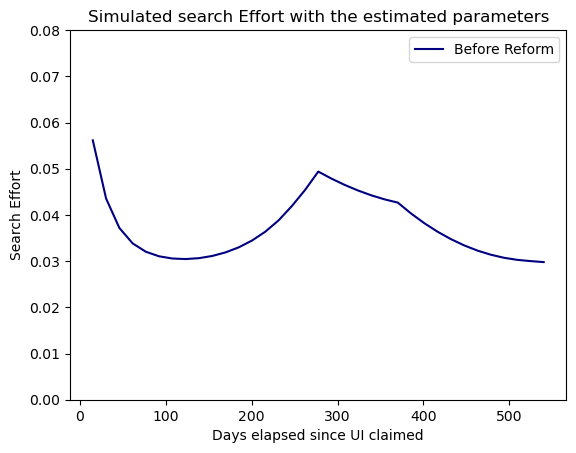

In [4]:
model.solve_ConSav()
sim = model.sim.s_total
time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, sim[:], color='navy', label='Before Reform') 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.ylim(0.0, 0.08)
plt.legend()
plt.show()

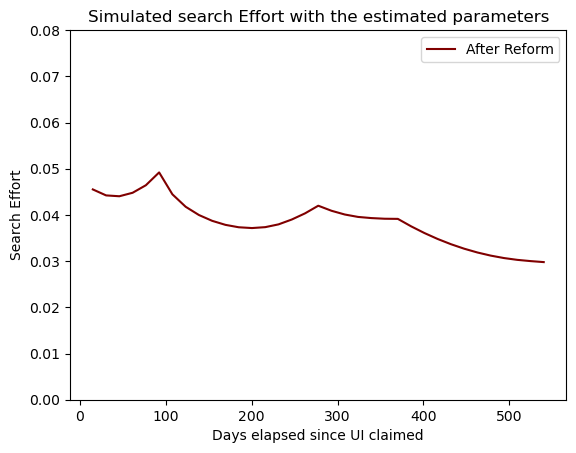

In [5]:
model_after = deepcopy(model)
model_after.par.b1 = 342.0/675.0      # Value after reform
model_after.par.b2 = 171.0/675.0      # Value after reform

model_after.allocate()
model_after.solve_ConSav()
s_forecast = model_after.sim.s_total

true_data_outofsample = model.data.moments_after
true_data_insample = model.data.moments_before
mse_eta1_outofsample = np.mean((true_data_outofsample - s_forecast)**2)
mse_eta1_insample = np.mean((true_data_insample - sim)**2)

# Now plotting s_forecast
time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, s_forecast, label='After Reform', color='maroon')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

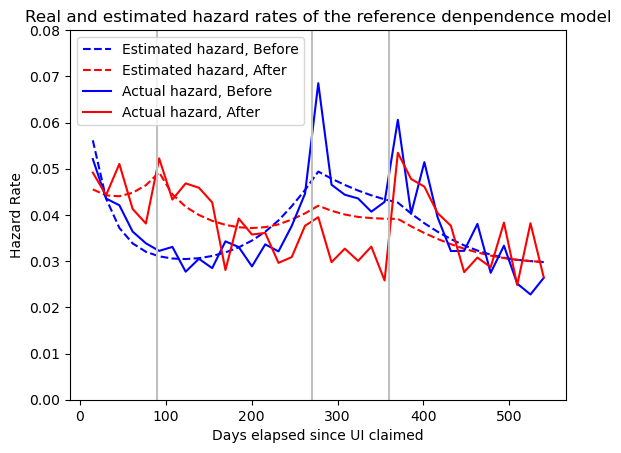

In [6]:
#Replicating figure 7(b) from the paper
after = model_new.data.moments_after
before = model_new.data.moments_before

time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, sim[:model.par.T_sim], color='Blue', label='Estimated hazard, Before', linestyle='--')
plt.plot((time+1)*15, s_forecast, label='Estimated hazard, After', color='Red', linestyle='--')
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='Blue')
plt.plot((time+1)*15, after, label='Actual hazard, After', color='Red')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.title('Real and estimated hazard rates of the reference denpendence model')
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

# Model with **NO** reference dependence (standard model)

In [7]:
# model_new = deepcopy(model)

model_new.par.eta = 0.0     # Removes reference dependence
# model_new.par.full_sample_estimation = True
model_new.allocate()

est_par = ['gamma', 'cost1', 'cost2', 'cost3', 'type_shares1', 'type_shares3', 'Welfare'] # Parameters to estimate
theta0 = [0.9, 84, 242, 310, 0.4, 0, 0.1] # Initial guesses
bounds = [(0.01, 50.0), (0.0, model_new.par.cost2), (model_new.par.cost1,model_new.par.cost3), (model_new.par.cost2,700.0), (0,1), (0,1), (0,model.par.b3)] # Bounds for the parameters

est = method_simulated_moments(model_new, est_par,theta0,bounds,weight=False)

print("Optimization Results:")
print("---------------------")
print(f'{"Parameter":<15} {"Estimate":<15}')
for param, estimate in zip(est_par, est.x):
    print(f'{param:<15} {estimate:>15.3f}')
print(f'Objective:               {est.fun:.4f}')
print(f'Number of iterations:    {est.nit}')

sol.s
2.451630576928388
sol.s
1.4114905165064322
sol.s
2.294835934089604
sol.s
1.545464481808336
sol.s
2.1984694797217172
sol.s
1.6302100477880967
sol.s
2.131132396659415
sol.s
1.6902099003534703
sol.s
2.081259270316543
sol.s
1.7349325482980953
sol.s
2.0431519189334746
sol.s
1.7692047635028523
sol.s
2.0135071308774415
sol.s
1.7958949992160418
sol.s
1.9901962499593038
sol.s
1.816884459690205
sol.s
1.9717449852018092
sol.s
1.8334911971484038
sol.s
1.9570807111606405
sol.s
1.846680809347576
sol.s
1.4725813537923165
sol.s
1.7058762820889204
sol.s
1.5656472353388555
sol.s
1.6528249297909638
sol.s
1.5994551703312505
sol.s
1.6324934023124615
sol.s
2.451630576928388
sol.s
1.4114905165064322
sol.s
2.294835934089604
sol.s
1.545464481808336
sol.s
2.1984694797217172
sol.s
1.6302100477880967
sol.s
2.131132396659415
sol.s
1.6902099003534703
sol.s
2.081259270316543
sol.s
1.7349325482980953
sol.s
2.0431519189334746
sol.s
1.7692047635028523
sol.s
2.0135071308774415
sol.s
1.7958949992160418
sol.s
1.9901

c:\Users\marti\OneDrive - University of Copenhagen\Økonomi\8. semester\Dynamic Prog\old_version\consumption_saving.py:380: RuntimeWarning: invalid value encountered in divide
  type_shares = type_shares / sum(type_shares)


Optimization Results:
---------------------
Parameter       Estimate       
gamma                     0.071
cost1                    84.683
cost2                   341.545
cost3                   310.000
type_shares1              0.216
type_shares3              0.000
Welfare                   0.100
Objective:               0.4438
Number of iterations:    23


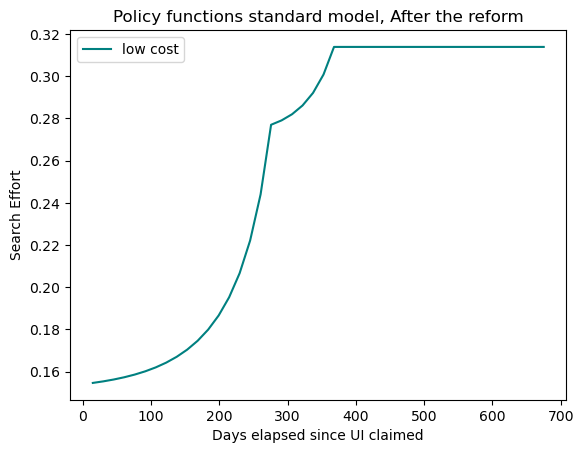

In [8]:
value_function_employment_ConSav(model_new.par, model_new.sol)
solve_search_and_consumption_ConSav(model_new.par, model_new.sol)
search_effort_new = model_new.sol.s

time = np.linspace(0, model_new.par.T, model_new.par.T)
plt.plot((time+1)*15, search_effort_new[0,:], label = 'low cost', color='teal') 
# plt.plot((time+1)*15, search_effort_new[1,:], label = 'medium cost', color='orange') 
# plt.plot((time+1)*15, search_effort_new[2,:], label = 'high', color='brown' ) 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Policy functions standard model, After the reform')
plt.legend()
plt.show()

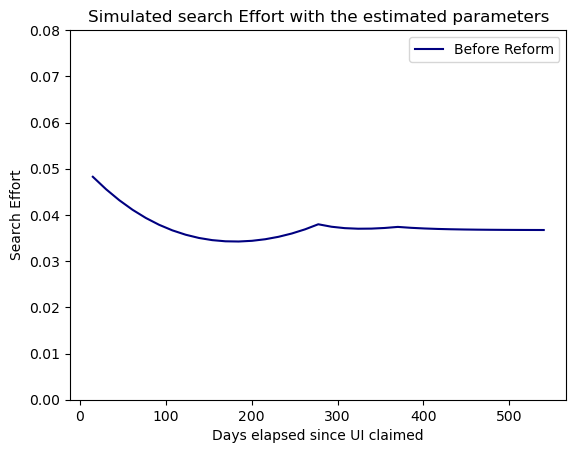

In [9]:
model_new.solve_ConSav()
sim_new = model_new.sim.s_total

time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)
plt.plot((time+1)*15, sim_new[:], label='Before Reform', color='navy') 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()


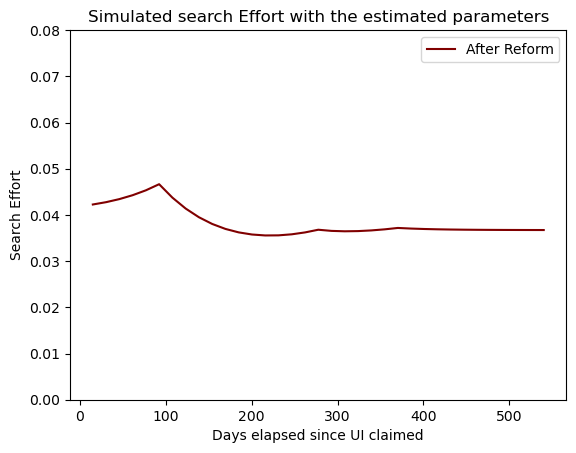

In [10]:
model_new.par.b1 = 342.0/675.0      # Value after reform
model_new.par.b2 = 171.0/675.0      # Value after reform

model_new.allocate()
model_new.solve_ConSav()
s_forecast_new = model_new.sim.s_total

# Now plotting s_forecast
time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)
plt.plot((time+1)*15, s_forecast_new, label='After Reform', color='maroon')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

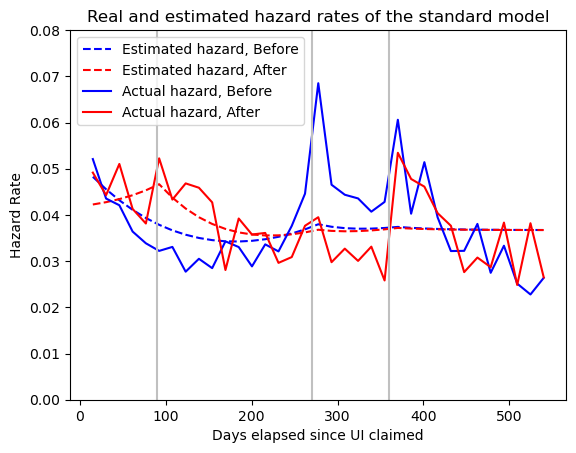

In [11]:
#Replicating figure 7(a) from the paper

time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)
plt.plot((time+1)*15, sim_new, color='Blue', label='Estimated hazard, Before', linestyle='--')
plt.plot((time+1)*15, s_forecast_new, label='Estimated hazard, After', color='Red', linestyle='--')
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='Blue')
plt.plot((time+1)*15, after, label='Actual hazard, After', color='Red')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.title('Real and estimated hazard rates of the standard model')
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

# **Comparison of the standard model and reference dependence**
### Through the Mean Square Error

In [12]:
true_data_outofsample = model_new.data.moments_after
true_data_insample = model_new.data.moments_before

# Get the mean square errors
mse_eta0_outofsample = np.mean((true_data_outofsample - s_forecast_new)**2)
mse_eta0_insample = np.mean((true_data_insample - sim_new)**2)

# Comparison out of sample
comparison1 = "smaller" if mse_eta1_outofsample < mse_eta0_outofsample else "bigger" if mse_eta1_outofsample > mse_eta0_outofsample else "equal"
comparison2 = "WITH reference dependence" if mse_eta1_outofsample < mse_eta0_outofsample else "WITHOUT reference dependence" 

# Comparison in sample
comparison3 = "smaller" if mse_eta1_insample < mse_eta0_insample else "bigger" if mse_eta1_insample > mse_eta0_insample else "equal"
comparison4 = "WITH reference dependence" if mse_eta1_insample < mse_eta0_insample else "WITHOUT reference dependence"


print("Before the reform: ")
print("-" * 100)
print(f"The mean square error from the model \033[1mwith\033[0m reference dependence is {mse_eta1_insample}")
print(f"The mean square error from the model \033[1mwithout\033[0m reference dependence is {mse_eta0_insample}")
print(f"The mean square error for the model \033[1mwith\033[0m reference dependence is \033[1m{comparison3}\033[0m than the model without.")
print(f"Best model: \033[1m{comparison4}\033[0m.")
print("-" * 100)



print("After the reform:")
print("-" * 100)
print(f"The mean square error from the model \033[1mwith\033[0m reference dependence is {mse_eta1_outofsample}")
print(f"The mean square error from the model \033[1mwithout\033[0m reference dependence is {mse_eta0_outofsample}")
print(f"The mean square error for the model \033[1mwith\033[0m reference dependence is \033[1m{comparison1}\033[0m than the model without.")
print(f"Best model: \033[1m{comparison2}\033[0m.")
print("-" * 100)

Before the reform: 
----------------------------------------------------------------------------------------------------
The mean square error from the model with reference dependence is 0.00014119530481157983
The mean square error from the model without reference dependence is 0.00010372307705891097
The mean square error for the model with reference dependence is bigger than the model without.
Best model: WITHOUT reference dependence.
----------------------------------------------------------------------------------------------------
After the reform:
----------------------------------------------------------------------------------------------------
The mean square error from the model with reference dependence is 8.954708823261304e-05
The mean square error from the model without reference dependence is 7.444958022459082e-05
The mean square error for the model with reference dependence is bigger than the model without.
Best model: WITHOUT reference dependence.
-----------------------

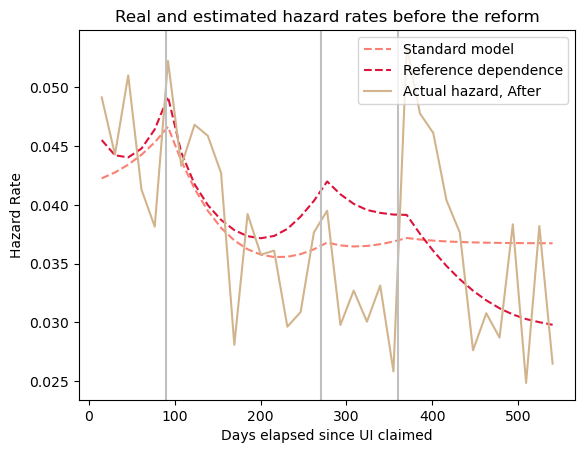

In [13]:
after = model_new.data.moments_after

time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)     # x-axis
plt.plot((time+1)*15, s_forecast_new, label='Standard model', color='salmon', linestyle='--')                     # Model with no reference dependence
plt.plot((time+1)*15, s_forecast, label='Reference dependence', color='crimson', linestyle='--')                         # Model with reference dependence
plt.plot((time+1)*15, after, label='Actual hazard, After', color='tan')                        # True data
# Make a vertical line at 90, 270 and 360
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.legend()
plt.title('Real and estimated hazard rates before the reform')
plt.show()

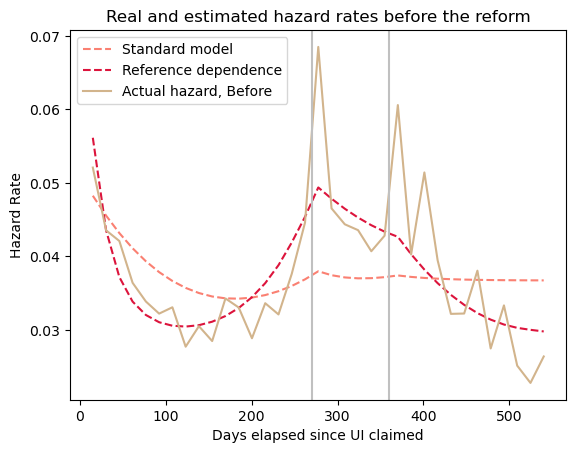

In [14]:
before = model_new.data.moments_before

time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)     # x-axis
plt.plot((time+1)*15, sim_new, label='Standard model', color='salmon', linestyle='--')                            # Model with no reference dependence
plt.plot((time+1)*15, sim, label='Reference dependence', color='crimson', linestyle='--')                                # Model with reference dependence
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='tan')                           # True data
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.legend()
plt.title('Real and estimated hazard rates before the reform')
plt.show()